# Setup Markdown




In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler, Normalizer
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#user profiles
user_profile_df = pd.read_csv("user_profile.csv")

#Users we want to give reccomendations to
test_users_df = pd.read_csv('rs_content_test.csv')[['user', 'item']]

# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import string

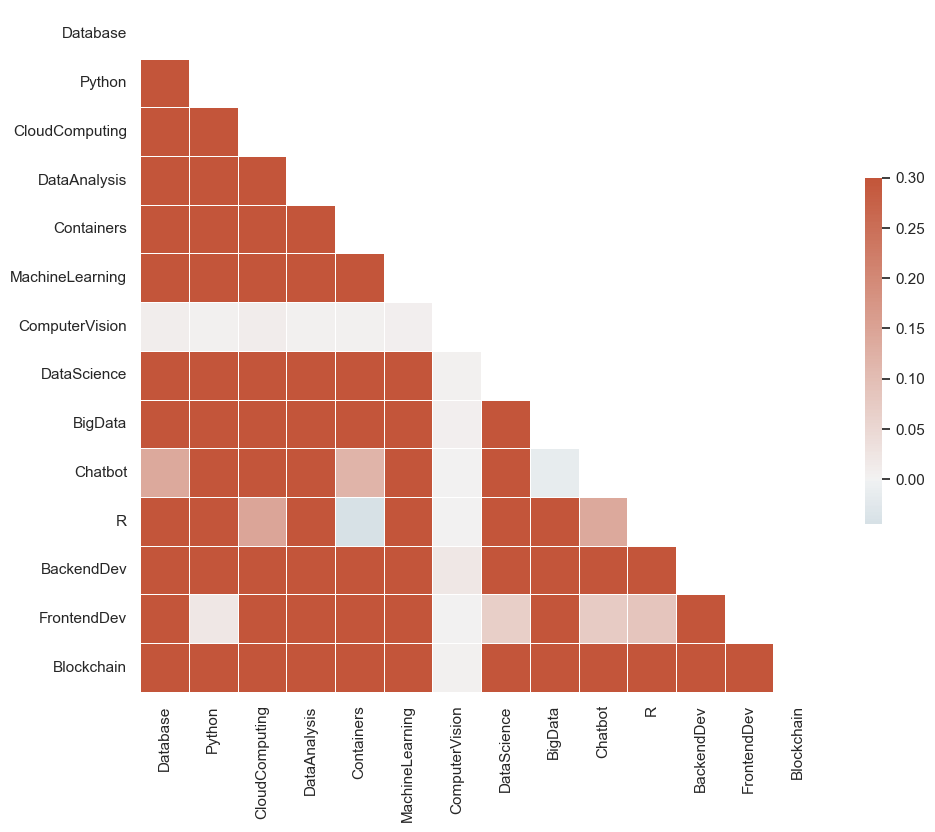

In [2]:
# Covaraiance matrix to see how features are correlated
features = user_profile_df.loc[:, user_profile_df.columns != 'user']

sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

In [3]:
def cluster_df_algorithm(scaler, cluster_optimizer, use_pca = None):
    # Load data
    df = pd.read_csv("user_profile.csv")
    feature_names = df.columns[1:]
    user_ids = df['user']

    # Normalize the feature vectors
    df[feature_names] = scaler.fit_transform(df[feature_names])
    X = df[feature_names].values
    
    if use_pca == True:
        # Define the parameter grid for the grid search
        param_grid = {'n_components': range(1, 15)}

        # Define the PCA model
        pca = PCA()

        # Define the grid search
        grid_search = GridSearchCV(pca, param_grid, cv=5)

        # Fit the grid search to the data
        grid_search.fit(X)

        # The optimal number of components can be found in the best_params_ attribute of the grid search
        optimal_num_components = grid_search.best_params_['n_components']

        # Get the PCA model with the optimal number of components
        #optimal_pca = PCA(n_components=optimal_num_components)
        optimal_pca = PCA(n_components=7)
        # Fit the PCA model to the data
        optimal_pca.fit(X)

        # Transform the data to the reduced number of components
        X_transformed = pca.transform(X)
        X = X_transformed
        # Get the variance explained by each component
        explained_variance = optimal_pca.explained_variance_ratio_

        # Calculate the accumulated variance
        accumulated_variance = [explained_variance[:i+1].sum() for i in range(len(explained_variance))]


        # Plot the number of components on the x-axis and the accumulated variance ratio on the y-axis as a bar plot
        plt.bar(range(1, len(explained_variance)+1), accumulated_variance)

        # Add a trendline to the bar plot
        z = np.polyfit(range(1, len(explained_variance)+1), accumulated_variance, 1)
        p = np.poly1d(z)
        plt.plot(range(1, len(explained_variance)+1), p(range(1, len(explained_variance)+1)), "r--")
        plt.title('PCA')
        plt.xlabel('Number of components')
        plt.ylabel('Accumulated variance ratio')
        plt.show()
        
        # Create a new dataframe with the user ids and transformed features
        df = pd.DataFrame({'user_id': user_ids, 'feature_1': X_transformed[:, 0], 'feature_2': X_transformed[:, 1], 
                           'feature_3': X_transformed[:, 2], 'feature_4': X_transformed[:, 3],
                           'feature_5': X_transformed[:, 4], 'feature_6': X_transformed[:, 5],
                           'feature_7': X_transformed[:, 6]})

    
    
    def combine_cluster_labels(user_ids, labels, X):
        labels_df = pd.DataFrame(labels)
        cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
        cluster_df.columns = ['user', 'cluster']
        score = silhouette_score(X, labels)
        return cluster_df, score

    if cluster_optimizer == 'gridsearch':
        # Define a custom scoring function that returns the sum of squared distances
        def sum_squared_distances(estimator, X):
            centers = estimator.cluster_centers_
            cluster_assignments = estimator.predict(X)
            sum_squared_distances = 0
            for i in range(estimator.n_clusters):
                mask = cluster_assignments == i
                sum_squared_distances += np.sum((X[mask] - centers[i]) ** 2)
            return sum_squared_distances

        # Create a k-means model
        kmeans = KMeans()
        # Define the range of clusters to try
        param_grid = {'n_clusters': range(1, 30)}

        # Use grid search to find the best number of clusters
        grid_search = GridSearchCV(kmeans, param_grid, scoring=sum_squared_distances, cv=5)
        grid_search.fit(X)

        def plot_grid_search(grid_search):
            # Extract the results from the grid search object
            results = grid_search.cv_results_
            n_clusters = results['param_n_clusters']
            mean_scores = results['mean_test_score']

            # Plot the mean cross-validation scores for each value of n_clusters
            plt.plot(n_clusters, mean_scores)
            plt.xlabel('Number of clusters')
            plt.ylabel('Mean cross-validation score')
            plt.show()

        plot_grid_search(grid_search)

        # Get the best number of clusters
        best_n_clusters = grid_search.best_params_['n_clusters']
        sum_squared_distances = -1 * grid_search.cv_results_['mean_test_score']
        # Use the best number of clusters to fit the model
        best_kmeans = KMeans(n_clusters=15)
        best_kmeans.fit(X)  
        cluster_labels = best_kmeans.labels_
        
        # If the optimizer is lowest sum of squares
    elif cluster_optimizer == 'lowest sum of squares':
            
            # Fit k-means model to find the optimal number of clusters
            model = KMeans()
            scores = []
            for n_clusters in range(1, 30):
                model.n_clusters = n_clusters
                model.fit(X)
                scores.append(-model.score(X))
            best_n_clusters = np.argmin(scores) + 1
            #model.n_clusters = best_n_clusters
            model.n_clusters = 22
            model.fit(X)
            # Assign cluster labels to each user
            clusters = model.predict(X)
            cluster_labels = model.labels_
              
    elif cluster_optimizer == 'gap_statistic':
            
            def optimize_clusters_gap_statistic(X, n_reference_datasets=10, max_clusters=30):
                #Random seed for reproducibility
                np.random.seed(64)
                # Generate reference datasets
                reference_datasets = [np.random.permutation(X) for _ in range(n_reference_datasets)]

                # Compute the gap statistic for each number of clusters
                gap_statistics = []
                for n_clusters in range(1, max_clusters+1):
                    model = KMeans(n_clusters=n_clusters)
                    model.fit(X)
                    Wk = model.inertia_
                    Wk_reference = [model.fit(X_reference).inertia_ for X_reference in reference_datasets]
                    gap = np.log(np.mean(Wk_reference)) - np.log(Wk)
                    gap_statistics.append(gap)

                # Choose the optimal number of clusters
                best_n_clusters = np.argmax(gap_statistics) + 1
                return best_n_clusters

            # Run the Gap statistic optimizer
            #best_n_clusters = optimize_clusters_gap_statistic(X)
            best_n_clusters = 19
            # Fit k-means model with the optimal number of clusters
            model = KMeans(n_clusters=best_n_clusters)
            model.fit(X)

            # Assign cluster labels to each user
            clusters = model.predict(X)
            cluster_labels = model.labels_
        
        

        
    cluster_df, score = combine_cluster_labels(user_ids, cluster_labels, X)
    return cluster_df, score

In [4]:
def cluster_item_enrol(cluster_df, test_users_df):
    #Merge the test_df with the cluster_df to assign cluster label to test user
    test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')

    #Enrollments count for each course in each group
    courses_cluster = test_users_labelled[['item', 'cluster']]
    courses_cluster['count'] = [1] * len(courses_cluster)
    cluster_item_enrol_df = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()
    return cluster_item_enrol_df, test_users_labelled

In [5]:
def reccomend_unseen(cluster_item_enrol_df, test_users_labelled, legacy_results_dict = None, hyperparms = None):
    # set threshold
    enrollment_count_threshold = 10
    # Filter the filtered_courses_df dataframe to only include courses with an enrollment count larger than the threshold
    popular_courses_df = cluster_item_enrol_df[cluster_item_enrol_df['enrollments'] > enrollment_count_threshold]
    # Find the courses in the popular_courses_df dataframe that are not in the list of courses taken by the test user
    unseen_courses = popular_courses_df[~popular_courses_df['item'].isin(test_users_labelled)]
    # Merge the test_users_labelled and cluster_item_enrol_df dataframes on the cluster and item columns
    merged_df = pd.merge(test_users_labelled, cluster_item_enrol_df, on=['cluster', 'item'])

    # Group the merged dataframe by the user column and get the list of courses taken by each test user
    test_user_courses = merged_df.groupby('user')['item'].apply(list).to_dict()

    # Initialize a dictionary to store the recommendation results for each test user
    recommendation_results = {}

    # Loop through the test users
    for user, cluster in test_users_labelled[['user', 'cluster']].values:
        # Filter the popular_courses_df dataframe to only include courses taken by users in the same cluster as the test user
        filtered_courses_df = popular_courses_df[popular_courses_df['cluster'] == cluster]

        # Get the list of courses taken by the test user or an empty list if the user is not found
        if user in test_user_courses:
            test_user_courses = test_user_courses[user]
        else:
            test_user_courses = []

    # Find the courses in the filtered dataframe that are not in the list of courses taken by the test user
    recommendations = filtered_courses_df[~filtered_courses_df['item'].isin(test_user_courses)]

    # Add the recommendation results for the test user to the dictionary
    recommendation_results[user] = recommendations

    # Calculate the mean number of recommendations for each user
    user_mean_recommendations = [len(recommendations) for recommendations in recommendation_results.values()]

    # Calculate the mean of the user_mean_recommendations list
    average_num_recommendations = np.mean(user_mean_recommendations)

    # Concatenate the dataframes in the recommendation_results dictionary into a single dataframe
    all_recommendations_df = pd.concat(recommendation_results.values())

    #Course counts
    course_counts_df = all_recommendations_df.groupby('item')['item'].count().reset_index(name='count')

    #What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users.
    top_10_courses = course_counts_df.sort_values(by='count', ascending=False).head(10)

    results_dict_new = {"all_recommendations_df":all_recommendations_df,"average_num_recommendations": average_num_recommendations, "user_mean_recommendations": user_mean_recommendations, "top_10_courses" :top_10_courses}
    if legacy_results_dict == True:
        for key in results_dict_new:
            results_dict_new[f'{key}_hyperparams'] = results_dict.pop(key)
        results_dict = legacy_results_dict.update(results_dict_new)
    else:
        results_dict = results_dict_new

    return results_dict

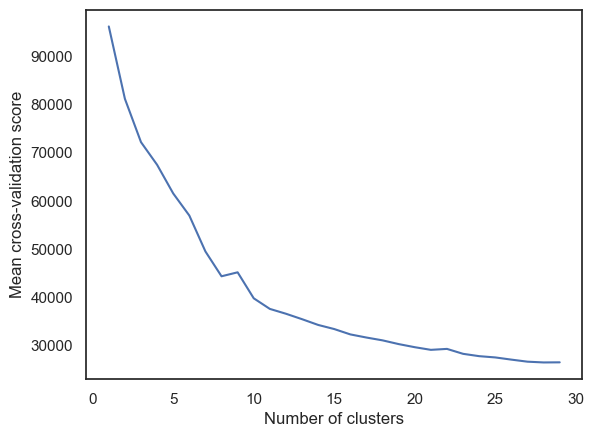

In [6]:
cluster_optimizer = 'gridsearch'
scaler = StandardScaler()
cluster_df, score_1 = cluster_df_algorithm(scaler = scaler, cluster_optimizer = cluster_optimizer, use_pca = False)
cluster_item_enrol_df, test_users_labelled = cluster_item_enrol(cluster_df, test_users_df)
results_dict_1 = reccomend_unseen(cluster_item_enrol_df, test_users_labelled, legacy_results_dict = None, hyperparms = 'grid_standard')

In [7]:
cluster_optimizer = 'lowest sum of squares'
scaler = StandardScaler()
cluster_df, score_2 = cluster_df_algorithm(scaler = scaler, cluster_optimizer = cluster_optimizer, use_pca = False)
cluster_item_enrol_df, test_users_labelled = cluster_item_enrol(cluster_df, test_users_df)
results_dict_2 = reccomend_unseen(cluster_item_enrol_df, test_users_labelled, legacy_results_dict = None, hyperparms = 'sse_standard')

In [8]:
cluster_optimizer = 'gap_statistic'
scaler = StandardScaler()
cluster_df, score_3 = cluster_df_algorithm(scaler = scaler, cluster_optimizer = cluster_optimizer, use_pca = False)
cluster_item_enrol_df, test_users_labelled = cluster_item_enrol(cluster_df, test_users_df)
results_dict_3 = reccomend_unseen(cluster_item_enrol_df, test_users_labelled, legacy_results_dict = None, hyperparms = 'gs_standard')

In [9]:
results_dict_1

{'all_recommendations_df':      cluster      item  enrollments
 778       12  BD0101EN          106
 779       12  BD0111EN          112
 780       12  BD0115EN           63
 781       12  BD0121EN           22
 783       12  BD0131EN           47
 787       12  BD0141EN           50
 788       12  BD0143EN           11
 792       12  BD0211EN           95
 793       12  BD0212EN           22
 809       12  DB0101EN           12
 810       12  DB0151EN           14
 813       12  DS0101EN           39
 814       12  DS0103EN           11
 830       12  ML0115EN           13
 836       12  PY0101EN           38
 840       12  SC0101EN           31
 841       12  SC0103EN           15
 843       12  ST0101EN           11
 848       12  WA0101EN           11,
 'average_num_recommendations': 19.0,
 'user_mean_recommendations': [19],
 'top_10_courses':         item  count
 0   BD0101EN      1
 10  DB0151EN      1
 17  ST0101EN      1
 16  SC0103EN      1
 15  SC0101EN      1
 14  PY0101EN  

In [20]:
score_list = [score_1 , score_2 , score_3]
print(score_list)
print(max(score_list))

[0.7633379375418389, 0.7731666887017289, 0.7706164853644847]
0.7731666887017289


In [22]:
results_dict_2['average_num_recommendations']

15.0

In [34]:
fin_df = results_dict_2['all_recommendations_df'].iloc[:,1:]


In [35]:
# Sort the dataframe by the 'size' column in descending order
sorted_courses = fin_df.sort_values(by='enrollments', ascending=False)
#Reset index
sorted_courses = sorted_courses.reset_index(drop=True)
sorted_courses.head(10)

,item,enrollments
0,BD0111EN,100
1,BD0101EN,94
2,BD0211EN,85
3,BD0115EN,57
4,BD0141EN,50
5,BD0131EN,46
6,DS0101EN,32
7,PY0101EN,32
8,SC0101EN,27
9,BD0212EN,21


[]

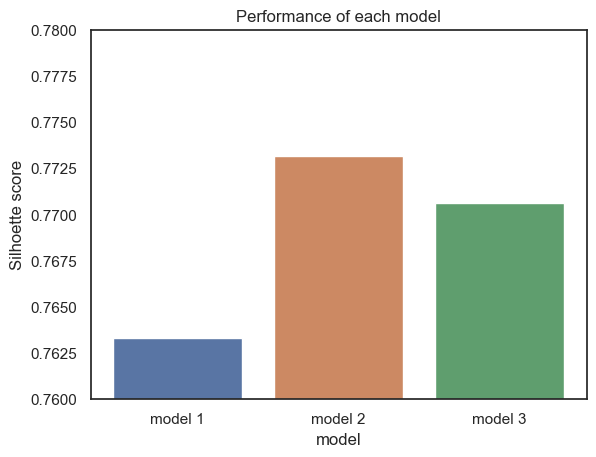

In [40]:
df_list_names = ['model 1', 'model 2', 'model 3']
import matplotlib.pyplot as plt
import seaborn as sns
# create a dataframe with the values and names
df_results_final = pd.DataFrame({'Silhoette score': score_list, 'model': df_list_names})

# use seaborn to plot the bar chart
sns.barplot(x='model', y='Silhoette score', data=df_results_final)
plt.title('Performance of each model')
plt.ylim(0.76, 0.78)
plt.plot()

In [41]:
sorted_courses['enrollments'].mean()

41.0

In [46]:
fin_df = results_dict_2['all_recommendations_df']

In [56]:
fin_df_2 = fin_df.sort_values(by='enrollments', ascending=False).head(10).reset_index(drop = True)

In [58]:
fin_df_3 = fin_df_2.iloc[:,1:]

In [60]:
course_genres_df = pd.read_csv('course_genre.csv')

In [61]:
merged_df = pd.merge(fin_df_3, course_genres_df, left_on='item', right_on='COURSE_ID')

In [63]:
merged_df.iloc[:,1:4]

,enrollments,COURSE_ID,TITLE
0,100,BD0111EN,hadoop 101
1,94,BD0101EN,big data 101
2,85,BD0211EN,spark fundamentals i
3,57,BD0115EN,mapreduce and yarn
4,50,BD0141EN,accessing hadoop data using hive
5,46,BD0131EN,moving data into hadoop
6,32,DS0101EN,introduction to data science
7,32,PY0101EN,python for data science
8,27,SC0101EN,scala 101
9,21,BD0212EN,spark fundamentals ii


In [65]:
fin_df['enrollments'].mean()

41.0